##1. Introduction




###1.1 Overview


* This document outlines a comprehensive approach to sentiment analysis on Twitter data, leveraging the power of advanced natural language processing models, BERT and Naive Bayes.

* The primary focus is to transform raw Twitter data into a format suitable for deep learning models, ensuring high-quality input for accurate sentiment classification.

### 1.2 Dependencies Installation


* Before diving into the data processing and analysis, it's crucial to set up the environment with the necessary Python libraries.
* The script relies on a range of libraries for data handling, processing, visualization, and machine learning tasks.

In [1]:
# Here is the command to install the primary dependency (emoji) for the script:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 5.2 MB/s eta 0:00:00


## 2. Environment Setup


### 2.1 Import Libraries

In [2]:
# Importing necessary libraries for data handling, processing, and visualization
import os
import re
import nltk
import emoji
import string
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for NLP and oversampling
from transformers import BertTokenizerFast
from imblearn.over_sampling import RandomOverSampler

### 2.2 Mount Google Drive

In [3]:
# Mounting Google Drive to access and store datasets
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## 3. Data Retrieval


### 3.1 Define Data Path



In [4]:
# Defining the path to the dataset zip file
data_dir = '/content/drive/My Drive/tweet_data.zip'

# Setting up the directory to extract the contents of the dataset
extract_to_dir = '/content/extracted_data'

### 3.2 Extract Dataset

In [5]:
# Extracting the zip file to the designated directory
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# Verifying the contents of the extracted dataset
extracted_contents = os.listdir(extract_to_dir)
print(f"Contents of '{extract_to_dir}': {extracted_contents}")

Contents of '/content/extracted_data': ['Corona_NLP_train.csv', 'Corona_NLP_test.csv']


## 4. Data Loading and Preprocessing



### 4.1 Load Data

In [6]:
# Loading training and testing data from the extracted files
df = pd.read_csv('/content/extracted_data/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/content/extracted_data/Corona_NLP_test.csv',encoding='ISO-8859-1')

#### 4.1.1 Training Data


In [7]:
# Displaying the first few rows of the training data
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


#### 4.1.2 Test Data

In [8]:
# Displaying the first few rows of the test data
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


### 4.2 Date Conversion and Deduplication

In [9]:
# Converting 'TweetAt' to datetime and removing duplicate tweets based on 'OriginalTweet'
df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df.drop_duplicates(subset='OriginalTweet',inplace=True)

<ipython-input-9-c1981bfe99f0>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


## 5. Data Exploration

### 5.1 Visualization of Tweets Over Time


In [10]:
# Counting and visualizing the number of tweets over time
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

<ipython-input-11-1da77a412892>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')


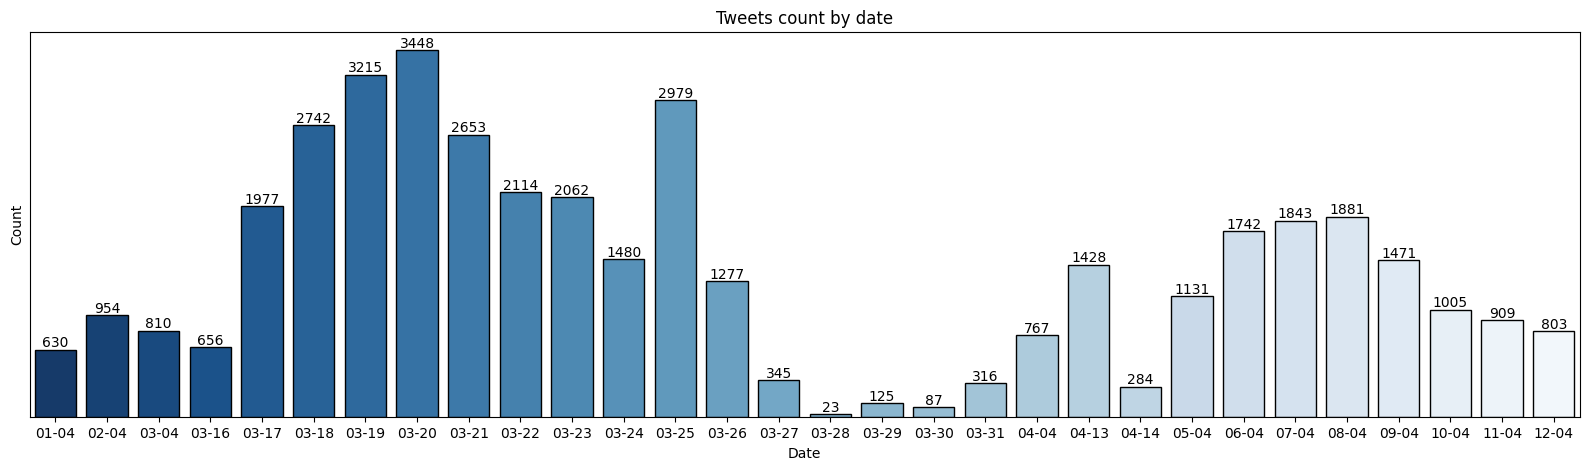

In [11]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Date')
plt.show()

### 5.2 Visualization of Tweets by Country



In [12]:
# Counting and visualizing the number of tweets by country
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

<ipython-input-13-24941281b9c5>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')


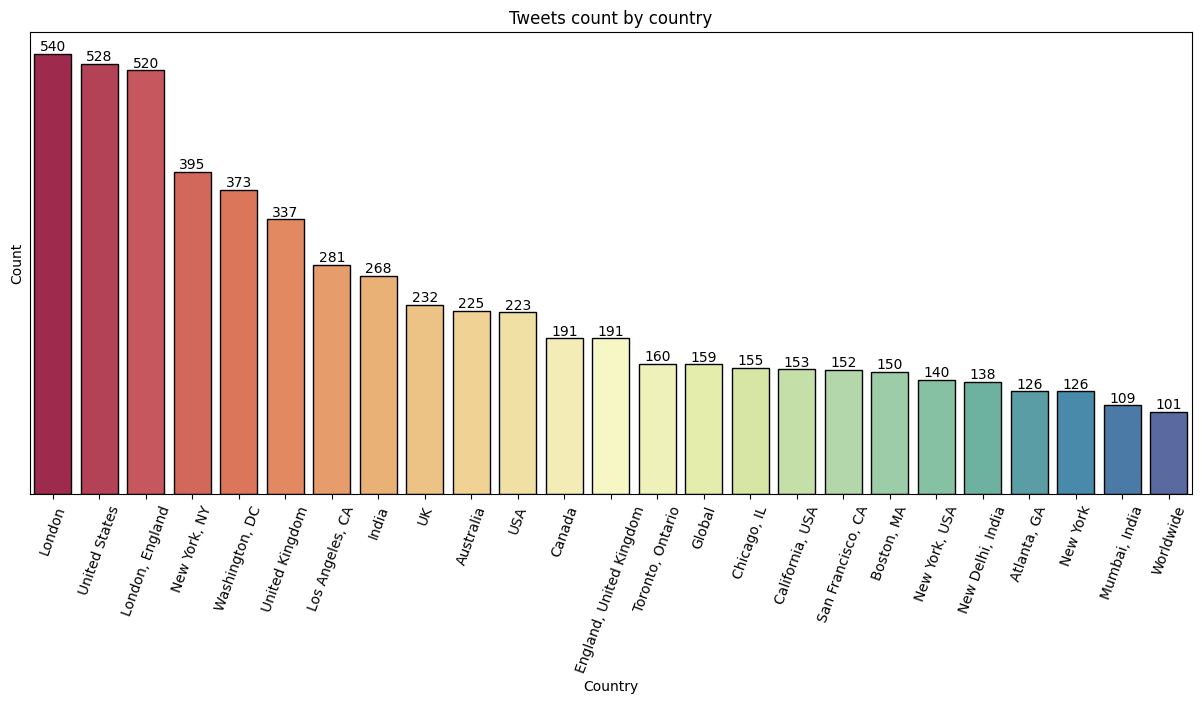

In [13]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('Country')
plt.show()

## 6. Text Cleaning and Preparation


In [14]:
# Narrowing down to relevant columns for analysis
df = df[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

### 6.1 Define Cleaning Functions


> Define a series of functions to clean and preprocess text data




#### 6.1.1 Emojis handling

In [15]:
#Clean emojis from text
def strip_emoji(text):
    # Pattern covering most emoji characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    # Replace all emojis in the text with an empty string (remove them)
    return emoji_pattern.sub(r'', text)

#### 6.1.2 Handling URLs, mentions, non-ASCII characters, etc..

In [16]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    # Remove carriage returns and newlines, and convert text to lowercase
    text = text.replace('\r', '').replace('\n', ' ').lower()
    # Remove URLs and mentions (anything starting with @ or http(s)://)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    # Define a list of characters to remove (punctuation + some additional characters)
    banned_list = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    # Create a translation table that maps each character to None (effectively removing it)
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#### 6.1.3 Hashtags clean up

In [17]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags that are at the end of the tweet
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    # Remove the # symbol from hashtags in the middle of the tweet
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

#### 6.1.4 Special characters Filter

In [18]:
#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        # If the word contains $ or &, replace it with an empty string
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    # Join the words back into a single string, separated by spaces
    return ' '.join(sent)

#### 6.1.5 Multiple space handling

In [19]:
def remove_mult_spaces(text):
    # Replace multiple spaces with a single space
    return re.sub("\s\s+" , " ", text)

### 6.2 Apply Cleaning to Data

#### 6.2.1 Training Data Cleaning


In [20]:
# Initialize an empty list to hold the cleaned tweets from the training data
texts_new = []

# Iterate over each tweet in the 'OriginalTweet' column of the DataFrame 'df'
for t in df.OriginalTweet:
    # Apply a series of cleaning functions to each tweet and append the cleaned tweet to 'texts_new'
    texts_new.append(
        remove_mult_spaces(  # Step 5: Reduce multiple spaces to a single space
            filter_chars(  # Step 4: Filter out words containing special characters like '&' and '$'
                clean_hashtags(  # Step 3: Clean up hashtags in the tweet
                    strip_all_entities(  # Step 2: Remove URLs, mentions, non-ASCII characters, etc.
                        strip_emoji(t)  # Step 1: Remove emojis from the tweet
                    )
                )
            )
        )
    )

df['text_clean'] = texts_new

#### 6.2.2 Test Data Cleaning


In [21]:
# Initialize an empty list to hold the cleaned tweets from the test data
texts_new_test = []

# Iterate over each tweet in the 'OriginalTweet' column of the DataFrame 'df_test'
for t in df_test.OriginalTweet:
    # Apply the same series of cleaning functions to each tweet and append the cleaned tweet to 'texts_new_test'
    texts_new_test.append(
        remove_mult_spaces(  # Step 5: Reduce multiple spaces to a single space
            filter_chars(  # Step 4: Filter out words containing special characters like '&' and '$'
                clean_hashtags(  # Step 3: Clean up hashtags in the tweet
                    strip_all_entities(  # Step 2: Remove URLs, mentions, non-ASCII characters, etc.
                        strip_emoji(t)  # Step 1: Remove emojis from the tweet
                    )
                )
            )
        )
    )

df_test['text_clean'] = texts_new_test

## 7. Post-cleaning Analysis

### 7.1 Length analysis for training data


In [22]:
# Analyze the length of tweets after cleaning and visualize the distribution
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

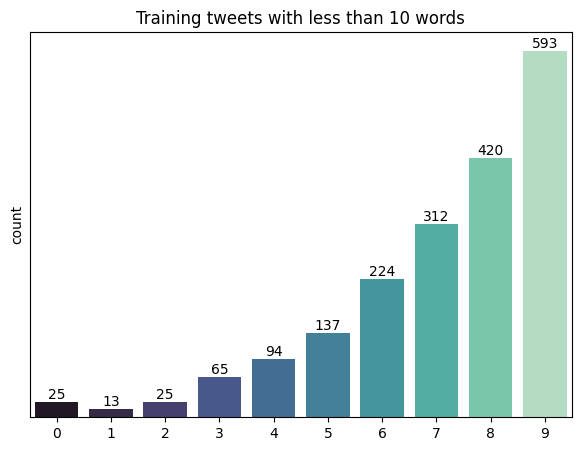

In [23]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### 7.2 Length analysis for testing data


In [24]:
# Analyze the length of tweets in the test data after cleaning and visualize the distribution
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

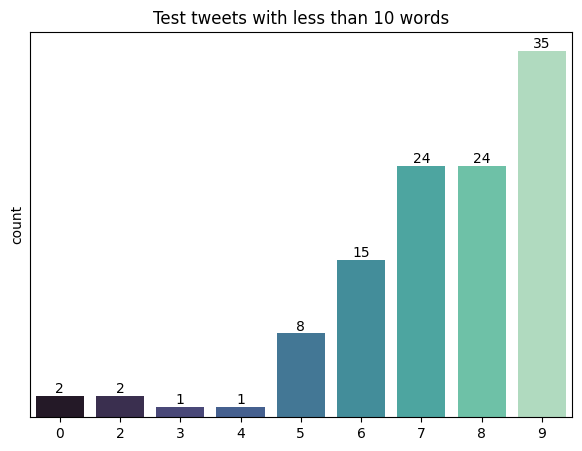

In [25]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

* As we can see, there are lots of cleaned tweets with 0 words
* This means that some tweets contained only mentions, hashtags or links, which have been removed **so we will drop these** empty tweets and also those with less than 5 words.

In [26]:
df = df[df['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]

## 8. Tokenization and Data Structuring


### 8.1 Text tokenization


In [27]:
# Initialize Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### 8.1.1 Token Length Analysis for training data


In [28]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len = np.max(token_lens)

df['token_lens'] = token_lens

In [29]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


#### 8.1.2 Token Length Analysis for testing data




In [30]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

df_test['token_lens'] = token_lens_test

In [31]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


### 8.2 Data Structuring


#### 8.2.1 Data shuffling

In [32]:
df = df.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

#### 8.2.2 Data Sorting

In [33]:
df = df.sort_values(by='token_lens', ascending=False)
df_test = df_test.sort_values(by='token_lens', ascending=False)

### 8.3 Sentiment Encoding


#### 8.3.1 Analyze Sentiment Distribution

In [34]:
# Analyzing the initial distribution of sentiments in the dataset
df['Sentiment'].value_counts()

Positive              11382
Negative               9890
Neutral                7567
Extremely Positive     6618
Extremely Negative     5478
Name: Sentiment, dtype: int64

#### 8.3.2 Encode Sentiment Labels

In [35]:
# Encoding sentiment labels to a simplified form
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

df['Sentiment'].value_counts()

2    18000
0    15368
1     7567
Name: Sentiment, dtype: int64

### 8.4 Apply Oversampling to Balance Data


In [36]:
# Balancing the dataset using RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

train_os['Sentiment'].value_counts()

1    18000
2    18000
0    18000
Name: Sentiment, dtype: int64

## 9. Saving Balanced and Encoded Data


In [37]:
# Save the training data
train_os.to_csv('/content/drive/My Drive/Cleaned_Training_Data.csv', index=False)

# Save the test data
df_test.to_csv('/content/drive/My Drive/Cleaned_Test_Data.csv', index=False)